# Driving7x7RoundAbout-n2-v0 KLR Experiment analysis

In [1]:
from pprint import pprint
import os.path as osp
from typing import List, Any, Optional, Tuple, Callable
from itertools import permutations, product

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import posggym_agents
import posggym_agents.exp.plot_utils as policy_plot_utils

import baposgmcp.plot as plot_utils
from baposgmcp.config import BASE_REPO_DIR

baposgmcp_results_file = osp.join(
    BASE_REPO_DIR, "experiments", "Driving", "Driving7x7RoundAbout-n2-v0", "results", "klr_experiment_results_v0.csv"
)
policy_results_file = osp.join(
    posggym_agents.config.BASE_DIR, 'agents', "driving7x7roundabout_n2_v0", "results", "klrbr_results.csv"
)

## Loading Heuristic Policy Data

In [2]:
policy_df = plot_utils.import_results(
    policy_results_file, clean_policy_id=True, add_coplayer_policy_id=True
)
policy_df.columns

coplayer_policy_ids = policy_df["policy_id"].unique().tolist()
coplayer_policy_ids.sort()
print(coplayer_policy_ids)

['klr_k0_seed0-v0', 'klr_k0_seed1-v0', 'klr_k0_seed2-v0', 'klr_k0_seed3-v0', 'klr_k0_seed4-v0', 'klr_k1_seed0-v0', 'klr_k1_seed1-v0', 'klr_k1_seed2-v0', 'klr_k1_seed3-v0', 'klr_k1_seed4-v0', 'klr_k2_seed0-v0', 'klr_k2_seed1-v0', 'klr_k2_seed2-v0', 'klr_k2_seed3-v0', 'klr_k2_seed4-v0', 'klr_k3_seed0-v0', 'klr_k3_seed1-v0', 'klr_k3_seed2-v0', 'klr_k3_seed3-v0', 'klr_k3_seed4-v0', 'klr_k4_seed0-v0', 'klr_k4_seed1-v0', 'klr_k4_seed2-v0', 'klr_k4_seed3-v0', 'klr_k4_seed4-v0', 'klrbr_k4_seed0-v0', 'klrbr_k4_seed1-v0', 'klrbr_k4_seed2-v0', 'klrbr_k4_seed3-v0', 'klrbr_k4_seed4-v0', 'uniform_random-v0']


## Loading BAPOSGMCP Data

In [3]:
baposgmcp_df = plot_utils.import_results(
    baposgmcp_results_file, clean_policy_id=True, add_coplayer_policy_id=True
)
policy_ids = baposgmcp_df["policy_id"].unique().tolist()
policy_ids.sort()
print("Policies")
print("--------")
for pi_id in policy_ids:
    print("  ", pi_id)

print("\nColumns")
print("-------")
for c in baposgmcp_df.columns:
    print("  ", f'"{c}",')

Policies
--------
   POMetaRollout_pucb_10
   POMetaRollout_pucb_100
   POMetaRollout_pucb_1000
   POMetaRollout_pucb_50
   POMetaRollout_pucb_500
   POMeta_10
   POMeta_100
   POMeta_1000
   POMeta_50
   POMeta_500
   baposgmcp_10
   baposgmcp_100
   baposgmcp_1000
   baposgmcp_50
   baposgmcp_500
   klr_k0_seed0-v0
   klr_k1_seed0-v0
   klr_k2_seed0-v0
   klr_k3_seed0-v0
   klr_k4_seed0-v0
   metabaseline

Columns
-------
   "Unnamed: 0.1",
   "policy_id",
   "coplayer_policy_id",
   "Unnamed: 0",
   "exp_id",
   "exp_seed",
   "agent_id",
   "env_name",
   "time_limit",
   "episode_step_limit",
   "discount",
   "c_init",
   "c_base",
   "truncated",
   "action_selection",
   "dirichlet_alpha",
   "root_exploration_fraction",
   "known_bounds",
   "extra_particles_prop",
   "step_limit",
   "epsilon",
   "belief_size",
   "other_policy_dist",
   "meta_policy_dict",
   "num_sims",
   "num_episodes",
   "num_WIN",
   "num_LOSS",
   "num_DRAW",
   "num_NA",
   "search_time_mean",
   "s

In [4]:
# Drop unneeded co-player policies
policies_to_keep = policy_ids
policy_df = policy_df[policy_df["policy_id"].isin(policies_to_keep)]
coplayer_policy_ids = policy_df["policy_id"].unique().tolist()
coplayer_policy_ids.sort()
print(coplayer_policy_ids)

['klr_k0_seed0-v0', 'klr_k1_seed0-v0', 'klr_k2_seed0-v0', 'klr_k3_seed0-v0', 'klr_k4_seed0-v0']


## Add Full-Knowledge Best-Response baseline

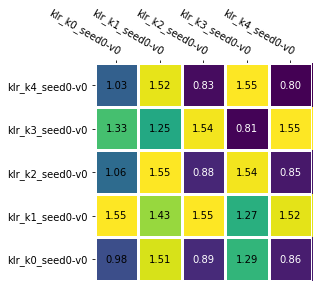

In [5]:
plot_utils.plot_pairwise_comparison(
    policy_df,
    y_key="episode_return_mean", 
    policy_key="policy_id",
    y_err_key=None,
    vrange=None, 
    figsize=(4, 4), 
    valfmt="{x:.2f}",
    coplayer_policies=coplayer_policy_ids,
    average_duplicates=False,
    duplicate_warning=False
)

In [6]:
best_response_map = {
    "klr_k0_seed0-v0": "klr_k1_seed0-v0",
    "klr_k1_seed0-v0": "klr_k2_seed0-v0",
    "klr_k2_seed0-v0": "klr_k3_seed0-v0",
    "klr_k3_seed0-v0": "klr_k4_seed0-v0",
    # FYI K4 is added but is not used in expected results, 
    # since K4 not in other policy prior
    "klr_k4_seed0-v0": "klr_k3_seed0-v0",
}

new_rows = []
for coplayer_policy_id, br_policy_id in best_response_map.items():
    next_exp_id = policy_df["exp_id"].max() + 1
    br_row = policy_df.loc[
        # use results from agent 0 so it's the same as BA-POSGMCP and other baseline results
        (policy_df["agent_id"] == 0)
        & (policy_df["policy_id"] == br_policy_id) 
        & (policy_df["coplayer_policy_id"] == coplayer_policy_id)
    ].copy()
    br_coplayer_row = policy_df.loc[
        (policy_df["agent_id"] == 1)
        & (policy_df["exp_id"].isin(br_row["exp_id"]))
    ].copy()
    # update policy id to baseline name
    br_row["policy_id"] = "full-knowledge-br"
    # update exp ids to avoid duplicates
    br_row["exp_id"] = next_exp_id
    br_coplayer_row["exp_id"] = next_exp_id
    new_rows.append(br_row)
    new_rows.append(br_coplayer_row)

print(len(new_rows))
br_df = pd.concat(new_rows, axis='rows').reset_index(drop=True)
print(len(br_df))
policy_br_df = pd.concat([policy_df, br_df], ignore_index=True)

print(len(policy_br_df))
policy_br_df[policy_br_df["policy_id"] == "full-knowledge-br"]
    

10
10
220


,Unnamed: 0,exp_id,agent_id,env_name,exp_seed,num_episodes,policy_seed,K,policy_id,dir_policy_id,...,num_WIN,num_NA,episode_return_CI,episode_steps_CI,episode_time_CI,prop_LOSS,prop_DRAW,prop_WIN,prop_NA,coplayer_policy_id
210,607,238,0,Driving7x7RoundAbout-n2-v0,0,1000,0,1,full-knowledge-br,pi_1,...,1000,0,0.003097,0.400286,0.011249,0.000,0.0,1.000,0.0,klr_k0_seed0-v0
212,807,238,0,Driving7x7RoundAbout-n2-v0,0,1000,0,2,full-knowledge-br,pi_2,...,1000,0,0.003097,0.147095,0.010360,0.000,0.0,1.000,0.0,klr_k1_seed0-v0
214,893,238,0,Driving7x7RoundAbout-n2-v0,0,1000,0,3,full-knowledge-br,pi_3,...,995,0,0.010529,0.137347,0.012084,0.005,0.0,0.995,0.0,klr_k2_seed0-v0
216,1228,238,0,Driving7x7RoundAbout-n2-v0,0,1000,0,4,full-knowledge-br,pi_4,...,1000,0,0.003098,0.125020,0.011564,0.000,0.0,1.000,0.0,klr_k3_seed0-v0
218,928,238,0,Driving7x7RoundAbout-n2-v0,0,1000,0,3,full-knowledge-br,pi_3,...,1000,0,0.003096,0.123684,0.011814,0.000,0.0,1.000,0.0,klr_k4_seed0-v0


## Combine data

In [7]:
# First need to update exp_ids of one dataframe so there are no duplicate exp_ids
df1 = baposgmcp_df
df2 = policy_br_df

df1_max_exp_id = df1["exp_id"].max()
if df2["exp_id"].min() <= df1_max_exp_id:
    df2["exp_id"] += df1_max_exp_id+1

combined_df = pd.concat([df1, df2]).reset_index(drop = True)
    
policy_ids = combined_df["policy_id"].unique().tolist()
policy_ids.sort()
print("Policies")
print("--------")
for pi_id in policy_ids:
    print("  ", pi_id)

print("\nColumns")
print("-------")
for c in combined_df.columns:
    print("  ", c)

Policies
--------
   POMetaRollout_pucb_10
   POMetaRollout_pucb_100
   POMetaRollout_pucb_1000
   POMetaRollout_pucb_50
   POMetaRollout_pucb_500
   POMeta_10
   POMeta_100
   POMeta_1000
   POMeta_50
   POMeta_500
   baposgmcp_10
   baposgmcp_100
   baposgmcp_1000
   baposgmcp_50
   baposgmcp_500
   full-knowledge-br
   klr_k0_seed0-v0
   klr_k1_seed0-v0
   klr_k2_seed0-v0
   klr_k3_seed0-v0
   klr_k4_seed0-v0
   metabaseline

Columns
-------
   Unnamed: 0.1
   policy_id
   coplayer_policy_id
   Unnamed: 0
   exp_id
   exp_seed
   agent_id
   env_name
   time_limit
   episode_step_limit
   discount
   c_init
   c_base
   truncated
   action_selection
   dirichlet_alpha
   root_exploration_fraction
   known_bounds
   extra_particles_prop
   step_limit
   epsilon
   belief_size
   other_policy_dist
   meta_policy_dict
   num_sims
   num_episodes
   num_WIN
   num_LOSS
   num_DRAW
   num_NA
   search_time_mean
   search_time_std
   search_time_min
   search_time_max
   update_time_mean


## Pairwise performance by number of simulations

Here we look at the performance of each policy against each other policy including BAPOSGMCP using different number of simulations.

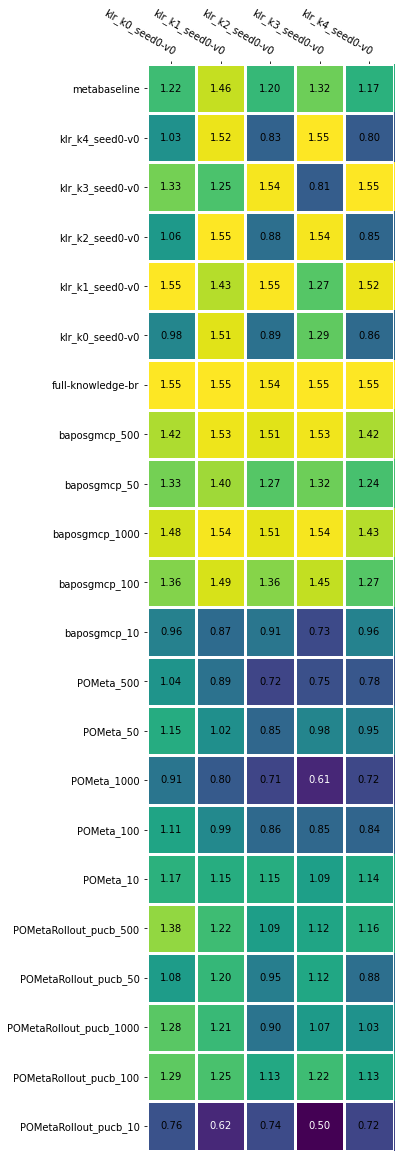

In [8]:
plot_utils.plot_pairwise_comparison(
    combined_df,
    y_key="episode_return_mean", 
    policy_key="policy_id",
    y_err_key=None,   # See next plot
    vrange=None, 
    figsize=(20, 20), 
    valfmt="{x:.2f}",
    coplayer_policies=coplayer_policy_ids,
    average_duplicates=True,
    duplicate_warning=False
)

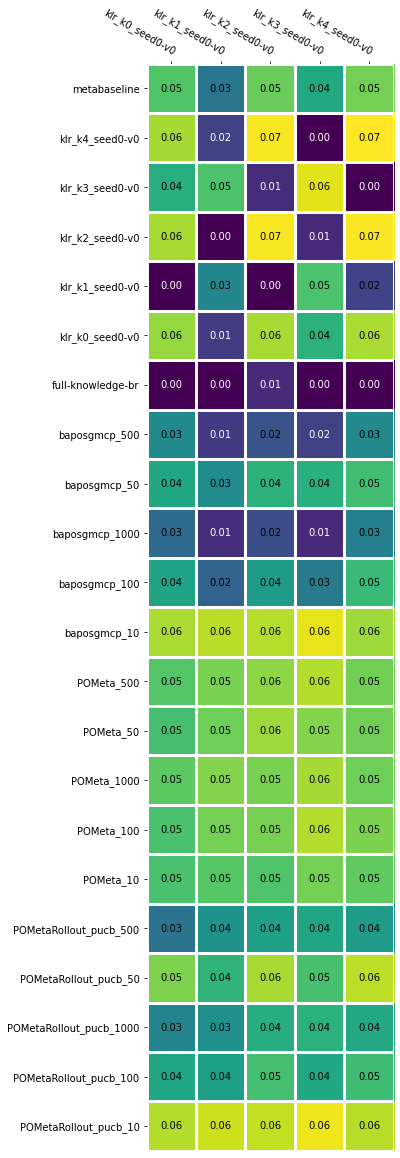

In [9]:
plot_utils.plot_pairwise_comparison(
    combined_df,
    y_key="episode_return_CI", 
    policy_key="policy_id",
    y_err_key=None,
    vrange=None, 
    figsize=(20, 20), 
    valfmt="{x:.2f}",
    coplayer_policies=coplayer_policy_ids,
    average_duplicates=True,
    duplicate_warning=False
)

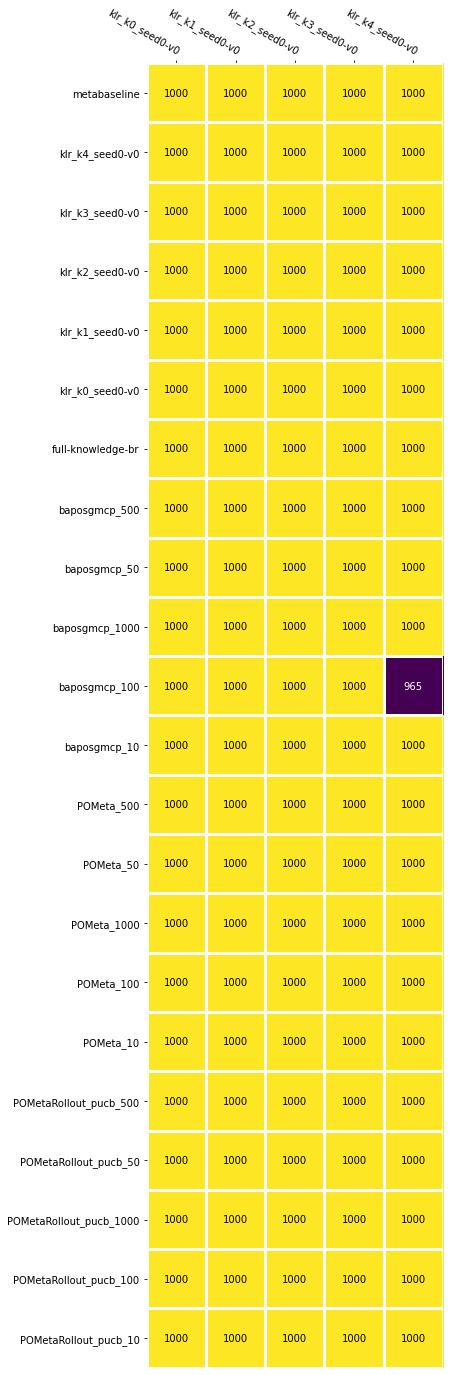

In [10]:
plot_utils.plot_pairwise_comparison(
    combined_df,
    y_key="num_episodes", 
    policy_key="policy_id",
    y_err_key=None,
    vrange=None, 
    figsize=(24, 24), 
    valfmt="{x:.0f}",
    coplayer_policies=coplayer_policy_ids,
    average_duplicates=True,
    duplicate_warning=False
)

## Policy Prior Performance

Here we look at the expected performance against the policy prior of BAPOSGMCP.

In [11]:
# Uniform
# Note K4 is not in prior 
policy_prior = {1: {
    'klr_k0_seed0-v0': 0.25,
    'klr_k1_seed0-v0': 0.25,
    'klr_k2_seed0-v0': 0.25,
    'klr_k3_seed0-v0': 0.25,
}}

pprint(policy_prior)

# Plot via num sims
policies_with_sims = [
    "POMetaRollout_pucb",
    "POMeta",
    "baposgmcp",
]

policies_without_sims = [
    "metabaseline",
    "full-knowledge-br"
]

{1: {'klr_k0_seed0-v0': 0.25,
     'klr_k1_seed0-v0': 0.25,
     'klr_k2_seed0-v0': 0.25,
     'klr_k3_seed0-v0': 0.25}}


In [12]:
expected_mean_returns_values, expected_mean_returns_err_values, policy_ids = plot_utils.get_expected_values_by_prior(
    combined_df,
    y_key="episode_return_mean",
    y_err_key="episode_return_CI",
    policy_key="policy_id",
    policy_prior=policy_prior
)
for i, policy_id in enumerate(policy_ids):
    value = expected_mean_returns_values[i]
    err_value = expected_mean_returns_err_values[i]
    print(f"{policy_id} = {value:.2f} +/- {err_value:.2f}")

POMetaRollout_pucb_10 = 0.65 +/- 0.06
POMetaRollout_pucb_100 = 1.22 +/- 0.04
POMetaRollout_pucb_1000 = 1.12 +/- 0.04
POMetaRollout_pucb_50 = 1.09 +/- 0.05
POMetaRollout_pucb_500 = 1.20 +/- 0.04
POMeta_10 = 1.14 +/- 0.05
POMeta_100 = 0.95 +/- 0.05
POMeta_1000 = 0.76 +/- 0.05
POMeta_50 = 1.00 +/- 0.05
POMeta_500 = 0.85 +/- 0.05
baposgmcp_10 = 0.87 +/- 0.06
baposgmcp_100 = 1.41 +/- 0.03
baposgmcp_1000 = 1.52 +/- 0.02
baposgmcp_50 = 1.33 +/- 0.04
baposgmcp_500 = 1.50 +/- 0.02
full-knowledge-br = 1.55 +/- 0.00
klr_k0_seed0-v0 = 1.17 +/- 0.04
klr_k1_seed0-v0 = 1.45 +/- 0.02
klr_k2_seed0-v0 = 1.26 +/- 0.03
klr_k3_seed0-v0 = 1.23 +/- 0.04
klr_k4_seed0-v0 = 1.23 +/- 0.04
metabaseline = 1.30 +/- 0.04


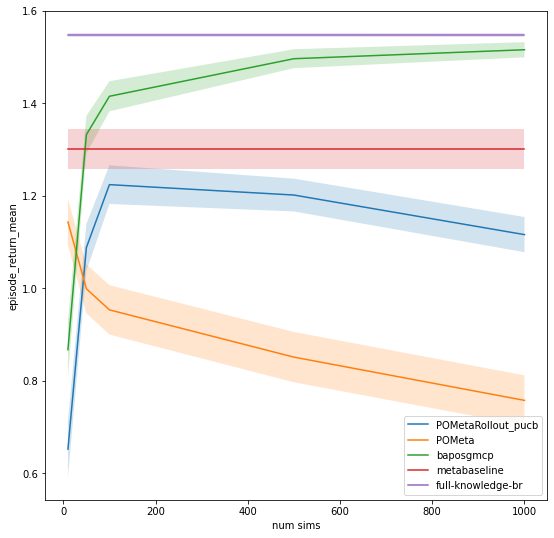

In [13]:
plot_utils.plot_expected_values_by_num_sims(
    y_key="episode_return_mean",
    expected_values=expected_mean_returns_values,
    expected_err_values=expected_mean_returns_err_values,
    policy_ids=policy_ids,
    policies_with_sims=policies_with_sims,
    policies_without_sims=policies_without_sims
)

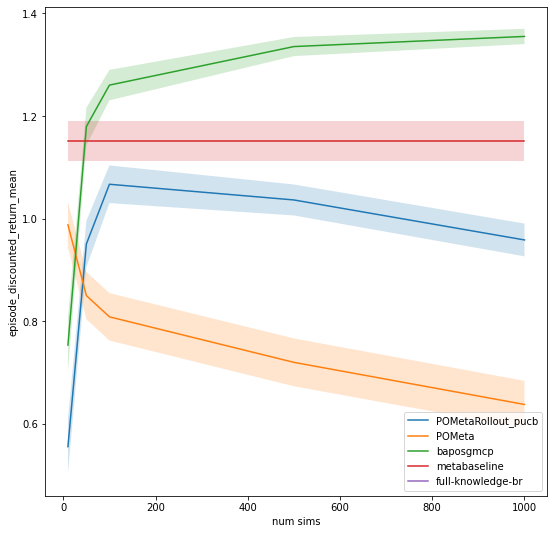

In [14]:
plot_utils.get_and_plot_expected_values_by_num_sims(
    combined_df,
    y_key="episode_discounted_return_mean",
    y_err_key="episode_discounted_return_CI",
    policy_key="policy_id",
    policy_prior=policy_prior,
    policies_with_sims=policies_with_sims,
    policies_without_sims=policies_without_sims
)

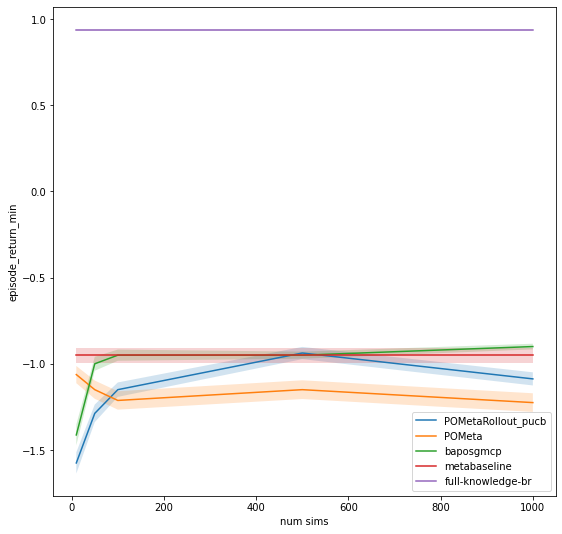

In [15]:
plot_utils.get_and_plot_expected_values_by_num_sims(
    combined_df,
    y_key="episode_return_min",
    y_err_key="episode_return_CI",
    policy_key="policy_id",
    policy_prior=policy_prior,
    policies_with_sims=policies_with_sims,
    policies_without_sims=policies_without_sims
)

## Looking at time

   - episode_steps
   - search_time
   - update_time
   - reinvigoration_time
   - policy_calls
   - inference_time
   - search_depth

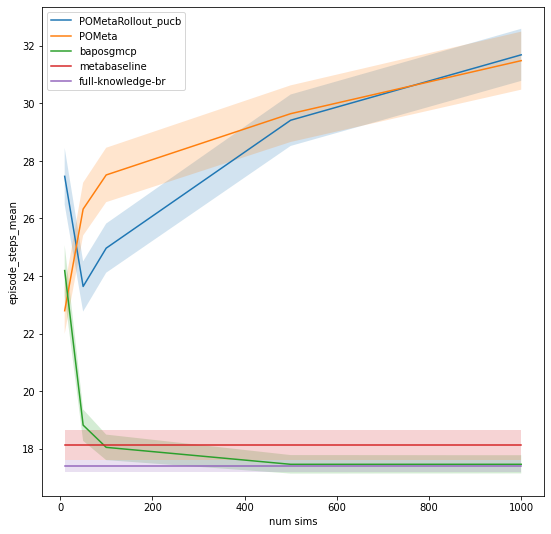

In [17]:
plot_utils.get_and_plot_expected_values_by_num_sims(
    combined_df,
    y_key="episode_steps_mean",
    y_err_key="episode_steps_CI",
    policy_key="policy_id",
    policy_prior=policy_prior,
    policies_with_sims=policies_with_sims,
    policies_without_sims=policies_without_sims
)

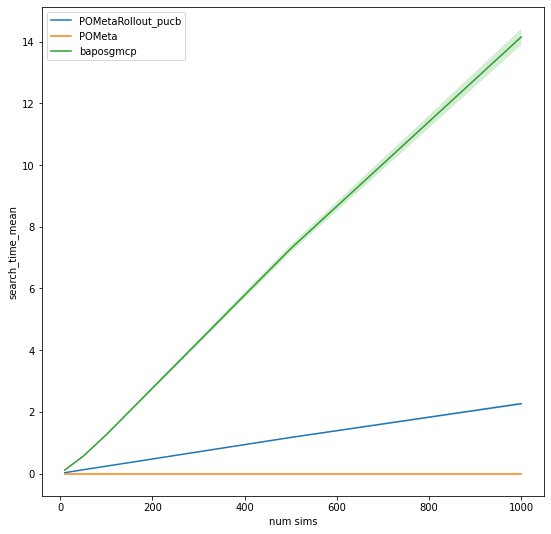

In [18]:
plot_utils.get_and_plot_expected_values_by_num_sims(
    combined_df,
    y_key="search_time_mean",
    y_err_key="search_time_CI",
    policy_key="policy_id",
    policy_prior=policy_prior,
    policies_with_sims=policies_with_sims,
    policies_without_sims=[]
)

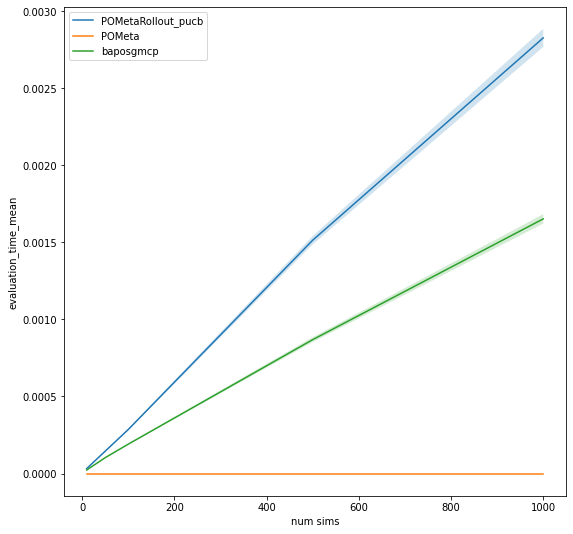

In [19]:
plot_utils.get_and_plot_expected_values_by_num_sims(
    combined_df,
    y_key="evaluation_time_mean",
    y_err_key="evaluation_time_CI",
    policy_key="policy_id",
    policy_prior=policy_prior,
    policies_with_sims=policies_with_sims,
    policies_without_sims=[]
)

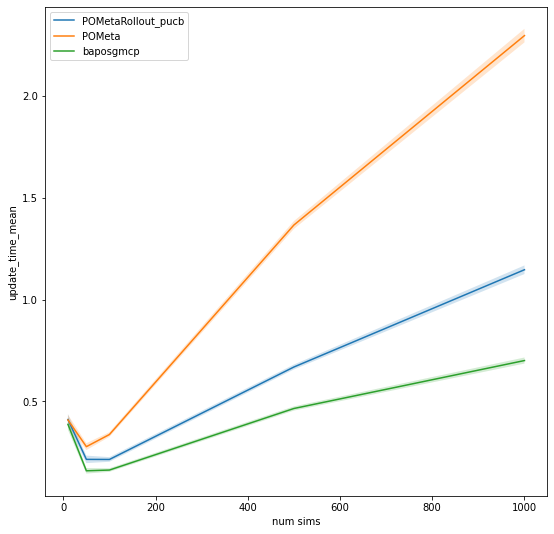

In [20]:
plot_utils.get_and_plot_expected_values_by_num_sims(
    combined_df,
    y_key="update_time_mean",
    y_err_key="update_time_CI",
    policy_key="policy_id",
    policy_prior=policy_prior,
    policies_with_sims=policies_with_sims,
    policies_without_sims=[]
)

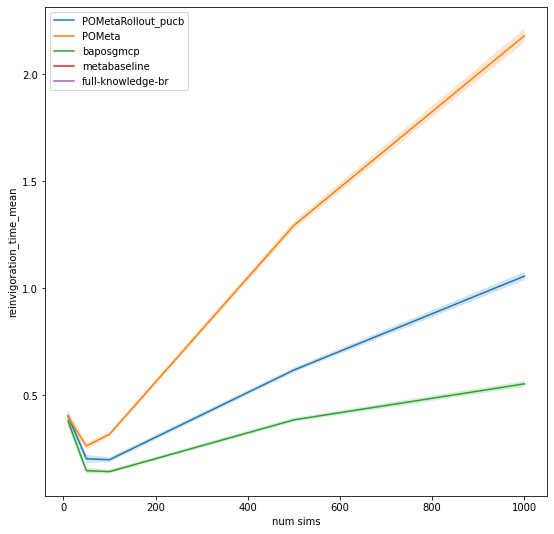

In [21]:
plot_utils.get_and_plot_expected_values_by_num_sims(
    combined_df,
    y_key="reinvigoration_time_mean",
    y_err_key="reinvigoration_time_CI",
    policy_key="policy_id",
    policy_prior=policy_prior,
    policies_with_sims=policies_with_sims,
    policies_without_sims=policies_without_sims
)

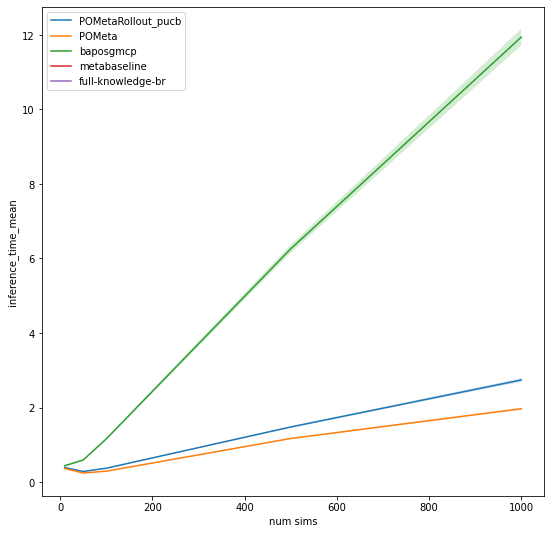

In [22]:
plot_utils.get_and_plot_expected_values_by_num_sims(
    combined_df,
    y_key="inference_time_mean",
    y_err_key="inference_time_CI",
    policy_key="policy_id",
    policy_prior=policy_prior,
    policies_with_sims=policies_with_sims,
    policies_without_sims=policies_without_sims
)

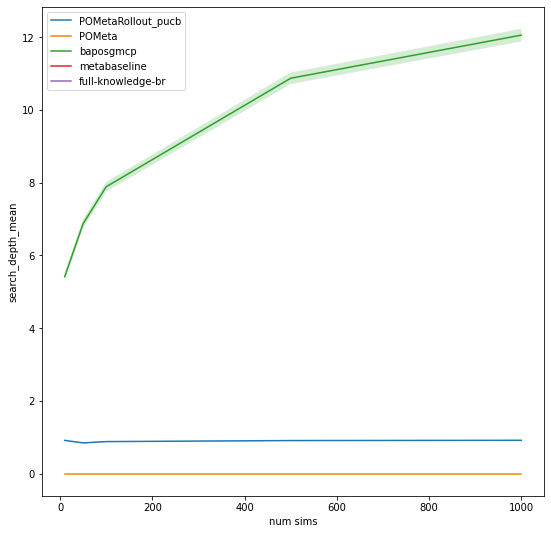

In [23]:
plot_utils.get_and_plot_expected_values_by_num_sims(
    combined_df,
    y_key="search_depth_mean",
    y_err_key="search_depth_CI",
    policy_key="policy_id",
    policy_prior=policy_prior,
    policies_with_sims=policies_with_sims,
    policies_without_sims=policies_without_sims
)

## Looking at Belief accuracy by steps

- action_dist_distance
- bayes_accuracy

In [24]:
policy_ids_by_alg = [
    ["baposgmcp_10", "baposgmcp_50", "baposgmcp_100", "baposgmcp_500", "baposgmcp_1000"],
]

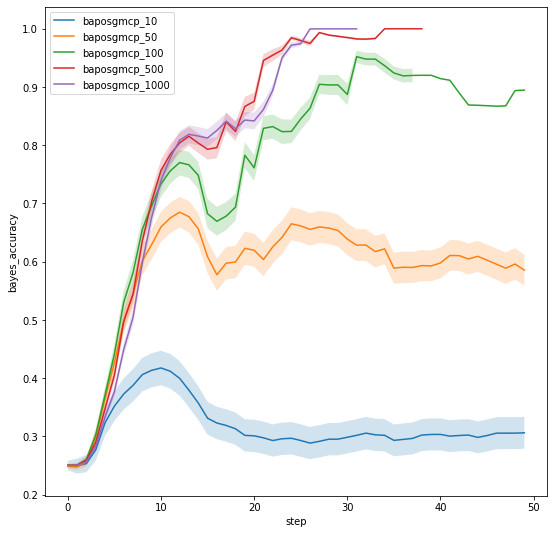

In [25]:
plot_utils.plot_expected_belief_stat_by_step(
    combined_df,
    y_key_prefix="bayes_accuracy",
    policy_ids=policy_ids_by_alg,
    policy_prior=policy_prior,
    step_limit=50,
    other_agent_id=1,
    policy_key="policy_id",
    coplayer_policy_key="coplayer_policy_id",
    y_suffix="mean",
    y_err_suffix="CI",
    figsize=(9, 9)
)

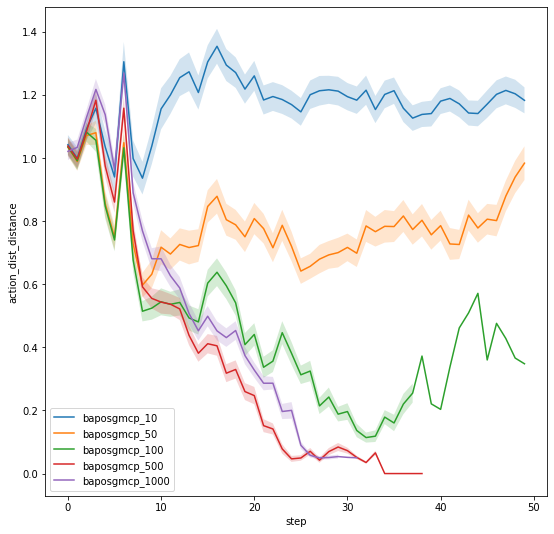

In [26]:
plot_utils.plot_expected_belief_stat_by_step(
    combined_df,
    y_key_prefix="action_dist_distance",
    policy_ids=policy_ids_by_alg,
    policy_prior=policy_prior,
    step_limit=50,
    other_agent_id=1,
    policy_key="policy_id",
    coplayer_policy_key="coplayer_policy_id",
    y_suffix="mean",
    y_err_suffix="CI",
    figsize=(9, 9)
)